## Import Library

In [29]:
# Import some libraries

import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
seed = 0
np.random.seed(seed)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'whitegrid')
import statistics

import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer
from keras.models import Sequential
from keras.layers import Embedding, Dense, Dropout, LSTM
from keras.optimizers import Adam, RMSprop, SGD
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

## Initialize Data

In [30]:
data_komentar = pd.read_csv('data/with_neutral_string.csv')
coments = data_komentar
coments

,id_komentar,sentimenc2,sentimenc2np,sentimenc3,komentar
0,4465,positive,positive,neutral,sepertinya tidak ada yang perlu dikritik
1,3922,positive,positive,positive,terimakasih sudah menjadi dosen yang mengerti ...
2,723,negative,negative,negative,untuk penjelasan meteri dan sebagainya mohon l...
3,2672,negative,negative,negative,seringnya perbatalan perkuliahan
4,3883,positive,positive,positive,menurut saya cara mengajar yang diterapkan sud...
...,...,...,...,...,...
4571,3364,negative,negative,negative,penjelasan disetiap materi kurang merinci maha...
4572,2287,positive,positive,positive,sudah bagus dalam penyampaian materi
4573,2622,negative,negative,negative,kualitas ajar yang kurang menyebabkan mahasisw...
4574,3315,positive,positive,positive,saya ngga ada kritik sama ibu pokoknya the bes...


## Fungsi untuk Preprocessing text

In [31]:
# Some functions for preprocessing text

def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # remove mentions
    text = re.sub(r'#[A-Za-z0-9]+', '', text) # remove hashtag
    text = re.sub(r'RT[\s]', '', text) # remove RT
    text = re.sub(r"http\S+", '', text) # remove link
    text = re.sub(r'[0-9]+', '', text) # remove numbers

    text = text.replace('\n', ' ') # replace new line into space
    text = text.translate(str.maketrans('', '', string.punctuation)) # remove all punctuations
    text = text.strip(' ') # remove characters space from both left and right text
    return text

def casefoldingText(text): # Converting all the characters in a text into lower case
    text = text.lower() 
    return text

def tokenizingText(text): # Tokenizing or splitting a string, text into a list of tokens
    text = word_tokenize(text) 
    return text

def filteringText(text): # Remove stopwors in a text
    listStopwords = set(stopwords.words('indonesian'))
    exclude_word = set(('tidak', 'bukan', 'kurang', 'belum', 'menyimpang', 'jangan', 'tak', 'tiada', 'engga', 'enggak', 'ndak', 'kagak'))
    finalStopword = listStopwords.difference(exclude_word)
    filtered = []
    for txt in text:
        if txt not in finalStopword:
            filtered.append(txt)
    text = filtered 
    return text

def stemmingText(text): # Reducing a word to its word stem that affixes to suffixes and prefixes or to the roots of words
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    text = [stemmer.stem(word) for word in text]
    return text

def toSentence(list_words): # Convert list of words into sentence
    sentence = ' '.join(word for word in list_words)
    return sentence

In [32]:
coments['text_clean'] = coments['komentar'].apply(cleaningText)
coments['text_clean']

0                sepertinya tidak ada yang perlu dikritik
1       terimakasih sudah menjadi dosen yang mengerti ...
2       untuk penjelasan meteri dan sebagainya mohon l...
3                        seringnya perbatalan perkuliahan
4       menurut saya cara mengajar yang diterapkan sud...
                              ...                        
4571    penjelasan disetiap materi kurang merinci maha...
4572                 sudah bagus dalam penyampaian materi
4573    kualitas ajar yang kurang menyebabkan mahasisw...
4574    saya ngga ada kritik sama ibu pokoknya the bes...
4575                       cara mengajar yang sangat baik
Name: text_clean, Length: 4576, dtype: object

In [33]:
coments['text_clean'] = coments['komentar'].apply(casefoldingText)
coments['text_clean']

0                sepertinya tidak ada yang perlu dikritik
1       terimakasih sudah menjadi dosen yang mengerti ...
2       untuk penjelasan meteri dan sebagainya mohon l...
3                        seringnya perbatalan perkuliahan
4       menurut saya cara mengajar yang diterapkan sud...
                              ...                        
4571    penjelasan disetiap materi kurang merinci maha...
4572                 sudah bagus dalam penyampaian materi
4573    kualitas ajar yang kurang menyebabkan mahasisw...
4574    saya ngga ada kritik sama ibu pokoknya the bes...
4575                       cara mengajar yang sangat baik
Name: text_clean, Length: 4576, dtype: object

In [34]:
coments.drop(['komentar'], axis = 1, inplace = True)

In [35]:
coments['text_preprocessed'] = coments['text_clean'].apply(tokenizingText)
coments['text_preprocessed']

0         [sepertinya, tidak, ada, yang, perlu, dikritik]
1       [terimakasih, sudah, menjadi, dosen, yang, men...
2       [untuk, penjelasan, meteri, dan, sebagainya, m...
3                    [seringnya, perbatalan, perkuliahan]
4       [menurut, saya, cara, mengajar, yang, diterapk...
                              ...                        
4571    [penjelasan, disetiap, materi, kurang, merinci...
4572           [sudah, bagus, dalam, penyampaian, materi]
4573    [kualitas, ajar, yang, kurang, menyebabkan, ma...
4574    [saya, ngga, ada, kritik, sama, ibu, pokoknya,...
4575                 [cara, mengajar, yang, sangat, baik]
Name: text_preprocessed, Length: 4576, dtype: object

In [36]:
coments['text_preprocessed'] = coments['text_preprocessed'].apply(filteringText)
coments['text_preprocessed']

0                                       [tidak, dikritik]
1               [terimakasih, dosen, mengerti, mahasiswa]
2         [penjelasan, meteri, mohon, diperjelas, ya, bu]
3                               [perbatalan, perkuliahan]
4                                  [mengajar, diterapkan]
                              ...                        
4571    [penjelasan, disetiap, materi, kurang, merinci...
4572                         [bagus, penyampaian, materi]
4573    [kualitas, ajar, kurang, menyebabkan, mahasisw...
4574    [ngga, kritik, pokoknya, the, best, buk, suka,...
4575                                           [mengajar]
Name: text_preprocessed, Length: 4576, dtype: object

In [37]:
coments['text_preprocessed'] = coments['text_preprocessed'].apply(stemmingText)
coments['text_preprocessed']

0                                         [tidak, kritik]
1                   [terimakasih, dosen, erti, mahasiswa]
2                    [jelas, meter, mohon, jelas, ya, bu]
3                                         [batal, kuliah]
4                                           [ajar, terap]
                              ...                        
4571    [jelas, tiap, materi, kurang, merinci, mahasis...
4572                              [bagus, sampai, materi]
4573    [kualitas, ajar, kurang, sebab, mahasiswa, tid...
4574    [ngga, kritik, pokok, the, best, buk, suka, ke...
4575                                               [ajar]
Name: text_preprocessed, Length: 4576, dtype: object

In [38]:
# drop duplicates/spams tweets
coments.drop_duplicates(subset = 'text_clean', inplace = True)

In [39]:
# Export to csv file
# coments.to_csv(r'data/coments_data_clean.csv', index = False, header = True,index_label=None)

# coments

## Analysis and Visualization

## Comparasion Class Sentiment on Data

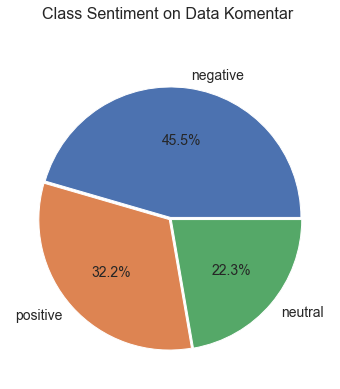

In [40]:
fig, ax = plt.subplots(figsize = (6, 6))
sizes = [count for count in coments['sentimenc3'].value_counts()]
labels = list(coments['sentimenc3'].value_counts().index)
explode = (0.01, 0.01, 0.01)
ax.pie(x = sizes, labels = labels, autopct = '%1.1f%%', explode = explode, textprops={'fontsize': 14})
ax.set_title('Class Sentiment on Data Komentar \n', fontsize = 16, pad = 20)
plt.show()

# Sentiment Analysis Using LSTM

## Preprocessing Text Data

In [41]:
# Make text preprocessed (tokenized) to untokenized with toSentence Function
X = coments['text_preprocessed'].apply(toSentence)
X

0                                            tidak kritik
1                        terimakasih dosen erti mahasiswa
2                           jelas meter mohon jelas ya bu
3                                            batal kuliah
4                                              ajar terap
                              ...                        
4571    jelas tiap materi kurang merinci mahasiswa tid...
4572                                  bagus sampai materi
4573    kualitas ajar kurang sebab mahasiswa tidak ert...
4574    ngga kritik pokok the best buk suka kelas ken ...
4575                                                 ajar
Name: text_preprocessed, Length: 4569, dtype: object

In [42]:
max_features = 5000

# Tokenize text with specific maximum number of words to keep, based on word frequency
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(X.values)

X = tokenizer.texts_to_sequences(X.values)

X

[[3, 13],
 [22, 9, 12, 4],
 [16, 1211, 33, 16, 56, 21],
 [551, 7],
 [1, 182],
 [1, 1, 21, 552, 1],
 [199, 553],
 [3, 18, 13, 413, 846, 1],
 [14, 2, 18, 1212],
 [3, 847, 9],
 [19, 233],
 [3, 13, 24, 7, 18, 1, 17, 10, 2],
 [3, 247, 4, 23],
 [9, 11, 12, 4, 7],
 [63, 7, 135],
 [124, 5, 12, 212],
 [65],
 [67, 414, 37, 7, 72, 2, 20, 10],
 [1, 17, 12],
 [74, 40, 479],
 [82, 1],
 [25, 2, 113, 10],
 [13, 3, 248, 1, 480, 65, 1, 222, 177, 131, 280, 1, 32, 78, 154, 41],
 [2, 30, 93, 17, 10],
 [267, 1213, 35],
 [114, 3, 19, 14, 2],
 [848, 1],
 [554, 45, 555, 342, 8, 99, 21, 183],
 [680, 481, 19, 343, 1214, 281, 183],
 [70, 29, 10, 2, 849, 5, 309, 70, 1215, 103, 29],
 [3, 13, 21],
 [7, 482, 162, 72, 67, 2, 850, 150],
 [15, 75],
 [3, 38, 1216, 3, 851],
 [2, 282, 5, 200, 29, 141],
 [1217],
 [5, 1218, 124, 4, 283, 124, 136, 1219],
 [310, 75],
 [5, 4, 2, 18, 16],
 [5, 16, 2, 4, 3, 4, 6, 1220, 16, 2],
 [33, 2],
 [33, 51, 5, 852, 282, 45, 43, 81, 6],
 [1, 374, 22],
 [5, 4, 12, 483],
 [681, 2],
 [9, 57, 29

In [43]:
X = pad_sequences(X)
X

array([[   0,    0,    0, ...,    0,    3,   13],
       [   0,    0,    0, ...,    9,   12,    4],
       [   0,    0,    0, ...,   16,   56,   21],
       ...,
       [   0,    0,    0, ...,    3,   12,    2],
       [   0,    0,    0, ...,  173,   52, 2634],
       [   0,    0,    0, ...,    0,    0,    1]])

In [44]:
X.shape

(4569, 34)

In [45]:
# Encode target data into numerical values
polarity_encode = {'negative' : 0, 'positive' : 1, 'neutral' : 2}
y = coments['sentimenc3'].map(polarity_encode).values

# Split the data (with composition data train 80%, data test 20%)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
# print(X_train.shape, y_train.shape)
# print(X_test.shape, y_test.shape)

## Model LSTM

In [46]:
# Create model function with default hyperparameter values

def create_model(embed_dim = 16, hidden_unit = 16, dropout_rate = 0.2, optimizers = Adam, learning_rate = 0.001):
    model = Sequential()
    model.add(Embedding(input_dim = max_features, output_dim = embed_dim, input_length = X.shape[1]))
    model.add(LSTM(units = hidden_unit, activation = 'tanh'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units = 3, activation = 'softmax'))
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer = optimizers(lr = learning_rate), metrics = ['accuracy'])
    print(model.summary())
    return model

In [47]:
# Results from hyperparameter tuning
results = pd.read_csv('data/gridsearchcv_results.csv')
results.sort_values(by='means', ascending = False).reset_index(drop=True)

,means,stds,params
0,0.916513,0.002494,"{'batch_size': 128, 'dropout_rate': 0.2, 'embe..."
1,0.916210,0.012881,"{'batch_size': 128, 'dropout_rate': 0.2, 'embe..."
2,0.915358,0.012066,"{'batch_size': 128, 'dropout_rate': 0.2, 'embe..."
3,0.915012,0.003830,"{'batch_size': 128, 'dropout_rate': 0.2, 'embe..."
4,0.912172,0.008714,"{'batch_size': 128, 'dropout_rate': 0.2, 'embe..."
...,...,...,...
283,0.651693,0.007537,"{'batch_size': 256, 'dropout_rate': 0.2, 'embe..."
284,0.651693,0.007537,"{'batch_size': 256, 'dropout_rate': 0.2, 'embe..."
285,0.651693,0.007537,"{'batch_size': 256, 'dropout_rate': 0.2, 'embe..."
286,0.651693,0.007537,"{'batch_size': 256, 'dropout_rate': 0.2, 'embe..."


In [48]:
# Create the model with the best hyperparameter which has been determined
model = KerasClassifier(build_fn = create_model,
                        # Model Parameters
                        dropout_rate = 0.2,
                        embed_dim = 32,
                        hidden_unit = 16,
                        optimizers = RMSprop,
                        learning_rate = 0.001,
                   
                        # Fit Parameters
                        epochs=10, 
                        batch_size=128,
                        # Initiate validation data, which is 10% data from data train. It's used for evaluation model
                        validation_split = 0.1)

In [61]:
scoring1 = ['accuracy', 'precision', 'recall', 'f1']

scoring = {'accuracy': make_scorer(accuracy_score),
            'precision': make_scorer(precision_score, average='macro'),
            'recall': make_scorer(recall_score, average='macro'),
            'f1': make_scorer(f1_score, average='macro')
            }

In [62]:
cv_score = cross_validate(model, X, y, cv=5, scoring=scoring)
cv_score

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_31 (Embedding)     (None, 34, 32)            160000    
_________________________________________________________________
lstm_31 (LSTM)               (None, 16)                3136      
_________________________________________________________________
dropout_31 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 3)                 51        
Total params: 163,187
Trainable params: 163,187
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Fury\Anaconda3\envs\myenviroment\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 3289 samples, validate on 366 samples
Epoch 1/10
3289/3289 [==============================] - 1s 262us/step - loss: 1.0631 - accuracy: 0.4658 - val_loss: 1.0495 - val_accuracy: 0.4235
Epoch 2/10
3289/3289 [==============================] - 0s 144us/step - loss: 0.9976 - accuracy: 0.4959 - val_loss: 0.9882 - val_accuracy: 0.5191
Epoch 3/10
3289/3289 [==============================] - 0s 148us/step - loss: 0.9061 - accuracy: 0.6190 - val_loss: 0.9120 - val_accuracy: 0.6093
Epoch 4/10
3289/3289 [==============================] - 0s 147us/step - loss: 0.8170 - accuracy: 0.6814 - val_loss: 0.8507 - val_accuracy: 0.6448
Epoch 5/10
3289/3289 [==============================] - 0s 143us/step - loss: 0.7439 - accuracy: 0.6972 - val_loss: 0.7822 - val_accuracy: 0.6421
Epoch 6/10
3289/3289 [==============================] - 0s 144us/step - loss: 0.6870 - accuracy: 0.7148 - val_loss: 0.7532 - val_accuracy: 0.6530
Epoch 7/10
3289/3289 [==============================] - ETA: 0s - loss: 0.634

C:\Users\Fury\Anaconda3\envs\myenviroment\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 3289 samples, validate on 366 samples
Epoch 1/10
3289/3289 [==============================] - 1s 259us/step - loss: 1.0628 - accuracy: 0.4561 - val_loss: 1.0468 - val_accuracy: 0.4699
Epoch 2/10
3289/3289 [==============================] - 0s 150us/step - loss: 0.9981 - accuracy: 0.5342 - val_loss: 0.9918 - val_accuracy: 0.5519
Epoch 3/10
3289/3289 [==============================] - 0s 144us/step - loss: 0.9232 - accuracy: 0.6181 - val_loss: 0.9203 - val_accuracy: 0.6120
Epoch 4/10
3289/3289 [==============================] - 0s 144us/step - loss: 0.8386 - accuracy: 0.6580 - val_loss: 0.8482 - val_accuracy: 0.6230
Epoch 5/10
3289/3289 [==============================] - 0s 144us/step - loss: 0.7604 - accuracy: 0.6890 - val_loss: 0.7982 - val_accuracy: 0.6448
Epoch 6/10
3289/3289 [==============================] - 0s 147us/step - loss: 0.6967 - accuracy: 0.7175 - val_loss: 0.7370 - val_accuracy: 0.6749
Epoch 7/10
3289/3289 [==============================] - 0s 152us/step - loss:

C:\Users\Fury\Anaconda3\envs\myenviroment\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 3289 samples, validate on 366 samples
Epoch 1/10
3289/3289 [==============================] - 1s 269us/step - loss: 1.0624 - accuracy: 0.4582 - val_loss: 1.0467 - val_accuracy: 0.4235
Epoch 2/10
3289/3289 [==============================] - 0s 149us/step - loss: 0.9972 - accuracy: 0.5227 - val_loss: 0.9937 - val_accuracy: 0.4836
Epoch 3/10
3289/3289 [==============================] - 0s 147us/step - loss: 0.9073 - accuracy: 0.6145 - val_loss: 0.9128 - val_accuracy: 0.6120
Epoch 4/10
3289/3289 [==============================] - 1s 155us/step - loss: 0.8202 - accuracy: 0.6689 - val_loss: 0.8467 - val_accuracy: 0.6339
Epoch 5/10
3289/3289 [==============================] - 0s 148us/step - loss: 0.7504 - accuracy: 0.6835 - val_loss: 0.8003 - val_accuracy: 0.6557
Epoch 6/10
3289/3289 [==============================] - 0s 146us/step - loss: 0.6969 - accuracy: 0.7045 - val_loss: 0.7880 - val_accuracy: 0.6366
Epoch 7/10
3289/3289 [==============================] - 1s 152us/step - loss:

C:\Users\Fury\Anaconda3\envs\myenviroment\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 3289 samples, validate on 366 samples
Epoch 1/10
3289/3289 [==============================] - 1s 259us/step - loss: 1.0558 - accuracy: 0.4612 - val_loss: 1.0459 - val_accuracy: 0.4235
Epoch 2/10
3289/3289 [==============================] - 1s 156us/step - loss: 0.9953 - accuracy: 0.5327 - val_loss: 0.9799 - val_accuracy: 0.5519
Epoch 3/10
3289/3289 [==============================] - 0s 149us/step - loss: 0.9115 - accuracy: 0.6212 - val_loss: 0.9381 - val_accuracy: 0.5601
Epoch 4/10
3289/3289 [==============================] - 0s 152us/step - loss: 0.8326 - accuracy: 0.6592 - val_loss: 0.8589 - val_accuracy: 0.6311
Epoch 5/10
3289/3289 [==============================] - 0s 148us/step - loss: 0.7664 - accuracy: 0.6823 - val_loss: 0.8034 - val_accuracy: 0.6421
Epoch 6/10
3289/3289 [==============================] - 1s 158us/step - loss: 0.7152 - accuracy: 0.6960 - val_loss: 0.7767 - val_accuracy: 0.6557
Epoch 7/10
3289/3289 [==============================] - 0s 151us/step - loss:

C:\Users\Fury\Anaconda3\envs\myenviroment\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 3290 samples, validate on 366 samples
Epoch 1/10
3290/3290 [==============================] - 1s 287us/step - loss: 1.0533 - accuracy: 0.4590 - val_loss: 1.0111 - val_accuracy: 0.4918
Epoch 2/10
3290/3290 [==============================] - 1s 160us/step - loss: 0.9711 - accuracy: 0.5556 - val_loss: 0.9194 - val_accuracy: 0.5847
Epoch 3/10
3290/3290 [==============================] - 0s 144us/step - loss: 0.8775 - accuracy: 0.6416 - val_loss: 0.8460 - val_accuracy: 0.6803
Epoch 4/10
3290/3290 [==============================] - 0s 147us/step - loss: 0.7964 - accuracy: 0.6799 - val_loss: 0.7835 - val_accuracy: 0.6940
Epoch 5/10
3290/3290 [==============================] - 0s 145us/step - loss: 0.7361 - accuracy: 0.6970 - val_loss: 0.7472 - val_accuracy: 0.7022
Epoch 6/10
3290/3290 [==============================] - 0s 145us/step - loss: 0.6946 - accuracy: 0.7003 - val_loss: 0.7268 - val_accuracy: 0.7022
Epoch 7/10
3290/3290 [==============================] - 0s 144us/step - loss:

{'fit_time': array([6.42334175, 6.92184901, 6.39873648, 6.45087457, 6.40250945]),
 'score_time': array([0.16201568, 0.17203474, 0.16498375, 0.15901971, 0.17100263]),
 'test_accuracy': array([0.70459519, 0.72319475, 0.71225383, 0.73304158, 0.70427163]),
 'test_precision': array([0.6847615 , 0.6906214 , 0.67735182, 0.73751861, 0.65103099]),
 'test_recall': array([0.63577998, 0.66908013, 0.62921588, 0.64835707, 0.62415459]),
 'test_f1': array([0.60757537, 0.67300066, 0.6139736 , 0.64328423, 0.62120157])}

In [63]:
cv_pred = cross_val_predict(model, X, y, cv=5)
print("Accuracy Score",accuracy_score(y, cv_pred))
print("Precision Score",precision_score(y, cv_pred, average='macro'))
print("Recall Score",recall_score(y, cv_pred, average='macro'))
print("F1 Score",f1_score(y, cv_pred, average='macro'))

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_36 (Embedding)     (None, 34, 32)            160000    
_________________________________________________________________
lstm_36 (LSTM)               (None, 16)                3136      
_________________________________________________________________
dropout_36 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_36 (Dense)             (None, 3)                 51        
Total params: 163,187
Trainable params: 163,187
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\Fury\Anaconda3\envs\myenviroment\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 3289 samples, validate on 366 samples
Epoch 1/10
3289/3289 [==============================] - 1s 263us/step - loss: 1.0542 - accuracy: 0.4591 - val_loss: 1.0339 - val_accuracy: 0.4262
Epoch 2/10
3289/3289 [==============================] - 0s 147us/step - loss: 0.9685 - accuracy: 0.5275 - val_loss: 0.9512 - val_accuracy: 0.5874
Epoch 3/10
3289/3289 [==============================] - 0s 144us/step - loss: 0.8698 - accuracy: 0.6461 - val_loss: 0.8781 - val_accuracy: 0.6448
Epoch 4/10
3289/3289 [==============================] - 0s 145us/step - loss: 0.7923 - accuracy: 0.6850 - val_loss: 0.8219 - val_accuracy: 0.6585
Epoch 5/10
3289/3289 [==============================] - 0s 146us/step - loss: 0.7292 - accuracy: 0.7066 - val_loss: 0.7811 - val_accuracy: 0.6530
Epoch 6/10
3289/3289 [==============================] - 0s 143us/step - loss: 0.6744 - accuracy: 0.7169 - val_loss: 0.7412 - val_accuracy: 0.6639
Epoch 7/10
3289/3289 [==============================] - 0s 146us/step - loss:

C:\Users\Fury\Anaconda3\envs\myenviroment\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 3289 samples, validate on 366 samples
Epoch 1/10
3289/3289 [==============================] - 1s 253us/step - loss: 1.0618 - accuracy: 0.4524 - val_loss: 1.0417 - val_accuracy: 0.4235
Epoch 2/10
3289/3289 [==============================] - 0s 147us/step - loss: 0.9866 - accuracy: 0.5388 - val_loss: 0.9708 - val_accuracy: 0.5710
Epoch 3/10
3289/3289 [==============================] - 0s 145us/step - loss: 0.8980 - accuracy: 0.6373 - val_loss: 0.9033 - val_accuracy: 0.6148
Epoch 4/10
3289/3289 [==============================] - 1s 154us/step - loss: 0.8156 - accuracy: 0.6783 - val_loss: 0.8328 - val_accuracy: 0.6530
Epoch 5/10
3289/3289 [==============================] - 1s 158us/step - loss: 0.7536 - accuracy: 0.6917 - val_loss: 0.7847 - val_accuracy: 0.6612
Epoch 6/10
3289/3289 [==============================] - 1s 171us/step - loss: 0.6991 - accuracy: 0.7072 - val_loss: 0.7692 - val_accuracy: 0.6585
Epoch 7/10
3289/3289 [==============================] - 1s 169us/step - loss:

C:\Users\Fury\Anaconda3\envs\myenviroment\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 3289 samples, validate on 366 samples
Epoch 1/10
3289/3289 [==============================] - 1s 256us/step - loss: 1.0639 - accuracy: 0.4804 - val_loss: 1.0513 - val_accuracy: 0.4235
Epoch 2/10
3289/3289 [==============================] - 1s 155us/step - loss: 1.0059 - accuracy: 0.5190 - val_loss: 0.9989 - val_accuracy: 0.5301
Epoch 3/10
3289/3289 [==============================] - 1s 185us/step - loss: 0.9248 - accuracy: 0.6142 - val_loss: 0.9451 - val_accuracy: 0.5519
Epoch 4/10
3289/3289 [==============================] - 1s 218us/step - loss: 0.8465 - accuracy: 0.6607 - val_loss: 0.8657 - val_accuracy: 0.6175
Epoch 5/10
3289/3289 [==============================] - 1s 219us/step - loss: 0.7735 - accuracy: 0.6917 - val_loss: 0.8168 - val_accuracy: 0.6421
Epoch 6/10
3289/3289 [==============================] - 1s 218us/step - loss: 0.7152 - accuracy: 0.6975 - val_loss: 0.7891 - val_accuracy: 0.6448
Epoch 7/10
3289/3289 [==============================] - 1s 219us/step - loss:

C:\Users\Fury\Anaconda3\envs\myenviroment\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 3289 samples, validate on 366 samples
Epoch 1/10
3289/3289 [==============================] - 1s 246us/step - loss: 1.0607 - accuracy: 0.4445 - val_loss: 1.0566 - val_accuracy: 0.4235
Epoch 2/10
3289/3289 [==============================] - 0s 145us/step - loss: 1.0247 - accuracy: 0.4658 - val_loss: 1.0227 - val_accuracy: 0.4317
Epoch 3/10
3289/3289 [==============================] - 0s 142us/step - loss: 0.9618 - accuracy: 0.5436 - val_loss: 0.9530 - val_accuracy: 0.5792
Epoch 4/10
3289/3289 [==============================] - 0s 143us/step - loss: 0.8841 - accuracy: 0.6379 - val_loss: 0.8960 - val_accuracy: 0.5847
Epoch 5/10
3289/3289 [==============================] - 0s 142us/step - loss: 0.8134 - accuracy: 0.6747 - val_loss: 0.8478 - val_accuracy: 0.6093
Epoch 6/10
3289/3289 [==============================] - 0s 148us/step - loss: 0.7510 - accuracy: 0.6947 - val_loss: 0.7803 - val_accuracy: 0.6585
Epoch 7/10
3289/3289 [==============================] - 1s 161us/step - loss:

C:\Users\Fury\Anaconda3\envs\myenviroment\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 3290 samples, validate on 366 samples
Epoch 1/10
3290/3290 [==============================] - 1s 252us/step - loss: 1.0628 - accuracy: 0.4565 - val_loss: 1.0226 - val_accuracy: 0.4727
Epoch 2/10
3290/3290 [==============================] - 0s 148us/step - loss: 0.9932 - accuracy: 0.5067 - val_loss: 0.9468 - val_accuracy: 0.5874
Epoch 3/10
3290/3290 [==============================] - 1s 157us/step - loss: 0.9121 - accuracy: 0.6207 - val_loss: 0.8876 - val_accuracy: 0.6885
Epoch 4/10
3290/3290 [==============================] - 1s 156us/step - loss: 0.8367 - accuracy: 0.6657 - val_loss: 0.8224 - val_accuracy: 0.6448
Epoch 5/10
3290/3290 [==============================] - 0s 147us/step - loss: 0.7786 - accuracy: 0.6875 - val_loss: 0.8340 - val_accuracy: 0.6093
Epoch 6/10
3290/3290 [==============================] - 0s 149us/step - loss: 0.7318 - accuracy: 0.6942 - val_loss: 0.7447 - val_accuracy: 0.6967
Epoch 7/10
3290/3290 [==============================] - 0s 147us/step - loss:

In [64]:
print("Accuracy each fold :", cv_score['test_accuracy'])
print("Precision each fold :", cv_score['test_precision'])
print("Recall each fold :", cv_score['test_recall'])
print("F1 each fold :", cv_score['test_f1'])

Accuracy each fold : [0.70459519 0.72319475 0.71225383 0.73304158 0.70427163]
Precision each fold : [0.6847615  0.6906214  0.67735182 0.73751861 0.65103099]
Recall each fold : [0.63577998 0.66908013 0.62921588 0.64835707 0.62415459]
F1 each fold : [0.60757537 0.67300066 0.6139736  0.64328423 0.62120157]


In [74]:
cv_pred

array([2, 1, 0, ..., 0, 1, 1], dtype=int64)

In [66]:
conf_mat = confusion_matrix(y, cv_pred)
conf_mat

array([[1807,  225,   47],
       [ 149, 1278,   45],
       [ 424,  404,  190]], dtype=int64)

In [68]:
print("Accuracy average :", cv_score['test_accuracy'].mean())
print("Precision average :", cv_score['test_precision'].mean())
print("Recall average :", cv_score['test_recall'].mean())
print("F1 average :", cv_score['test_f1'].mean())

Accuracy average : 0.7154713942301931
Precision average : 0.688256864980626
Recall average : 0.641317529521775
F1 average : 0.6318070857873468


In [70]:
print("Standard Deviation of Accuracy is % s " % (statistics.stdev(cv_score['test_accuracy'])))
print("Standard Deviation of Precision is % s " % (statistics.stdev(cv_score['test_precision'])))
print("Standard Deviation of Recall is % s " % (statistics.stdev(cv_score['test_recall'])))
print("Standard Deviation of F1 is % s " % (statistics.stdev(cv_score['test_f1'])))

Standard Deviation of Accuracy is 0.012474381472535021 
Standard Deviation of Precision is 0.03142138432726702 
Standard Deviation of Recall is 0.0179721857231353 
Standard Deviation of F1 is 0.0266754663280533 
